In [12]:
from easydict import EasyDict as edict
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
import sys
import os
from tqdm import tqdm

sys.path.append("../../")

In [3]:
from datasets.dataset import MoEDataset
from models import SingleExpertModel, BiomedCLIP

/home/yesindeed/anaconda3/envs/mmoe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
subsets = ["rsna-pulmonary-embolism", "chexpert",
           "lung-pet-ct-dx", "CC-CCII", "ssim-covid19"]
model_root = "/media/yesindeed/DATADRIVE1/mount/remote_cse/experiments/multitask-moe/biomedclip/seed0/lp"

models = []

for subset in subsets:
    backbone = BiomedCLIP()
    model = SingleExpertModel(backbone=backbone)
    ckpt = torch.load(os.path.join(
        model_root, f"train_{subset}", "checkpoint-best.pth"))
    model.load_state_dict(ckpt["model"])

    models.append(model.cuda())

In [56]:
test_set = MoEDataset(
    args=edict(input_size=224,
               data_root="/media/yesindeed/DATADRIVE1/mount/remote_cse/datasets/multitask-moe"),
    subsets="CC-CCII",
    split="test",
)

datasamples = Subset(test_set, range(200))

In [57]:
data_loader = DataLoader(datasamples, batch_size=1, shuffle=False)

image_features = []

with torch.no_grad():
    features = []
    for batch in data_loader:
        image = batch["image"].cuda()

        feature = models[0].backbone.encode_image(image)
        features.append(F.normalize(feature, dim=-1))

    features = torch.concat(features, dim=0).cpu().numpy()
    image_features.append(features)

    for model in tqdm(models):
        model.eval()

        features = []

        for batch in data_loader:
            image = batch["image"].cuda()

            feature = model.encode_image(image)

            features.append(feature)

        features = torch.concat(features, dim=0).cpu().numpy()
        image_features.append(features)

100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


In [66]:
texts = [
    "An image of diseased",
    "An image of no findings",
    "An image of adenocarcinoma",
    "An image of pleural effusion",
    "An image of pulmonary embolism",
]

with torch.no_grad():
    text_embeddings = models[0].backbone.encode_text(texts).cpu().numpy()

In [67]:
text_embeddings

array([[ 0.02312638, -0.01624499, -0.07265357, ...,  0.02091934,
        -0.01073013,  0.02833247],
       [ 0.03796462,  0.0031604 , -0.11302567, ..., -0.00251847,
        -0.04725767,  0.04013076],
       [ 0.00283217,  0.07047836, -0.05967787, ...,  0.01101448,
         0.04120974,  0.07422704],
       [ 0.01117889,  0.01459968, -0.07241472, ..., -0.02251101,
        -0.02681739,  0.01872335],
       [ 0.00777152, -0.02169245, -0.07053872, ...,  0.009111  ,
         0.01017738,  0.04115464]], dtype=float32)

In [60]:
import numpy as np
from sklearn.manifold import TSNE

In [68]:
image_features_concat = np.concatenate(image_features, axis=0)

features_embedded = TSNE(n_components=2, learning_rate="auto", perplexity=3).fit_transform(
    np.concatenate([text_embeddings, image_features_concat], axis=0)
)

/tmp/ipykernel_107187/3696830583.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


(5, 2)

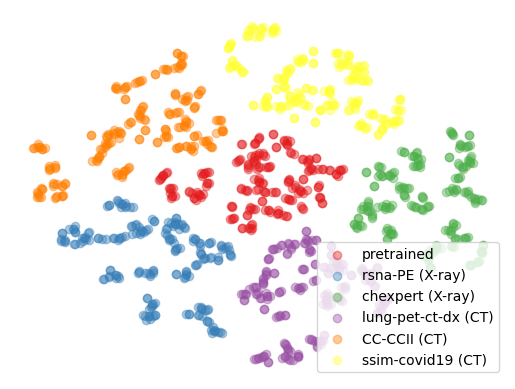

In [69]:
import matplotlib.pyplot as plt

plt.figure()
plt.axis("off")

colors = list([plt.cm.Set1(i) for i in range(8)])

text_features_embedded = features_embedded[: len(texts)]
image_features_embedded = features_embedded[len(
    texts):].reshape(len(subsets) + 1, 200, -1)
fused_image_features = image_features_embedded[0] * \
    0.5 + np.mean(image_features_embedded[1:], axis=0) * 0.5

subsets_plot = ["pretrained"] + [
    "rsna-PE (X-ray)",
    "chexpert (X-ray)",
    "lung-pet-ct-dx (CT)",
    "CC-CCII (CT)",
    "ssim-covid19 (CT)",
]


for i in range(len(subsets) + 1):
    plt.scatter(
        image_features_embedded[i, :, 0],
        image_features_embedded[i, :, 1],
        c=colors[i],
        alpha=0.4,
        label=subsets_plot[i],
    )

plt.legend(loc="lower right")

text_features_embedded.shape

# plt.scatter(text_features_embedded[0, 0],
#             text_features_embedded[0, 1], c="gray", marker="*", s=80)
# plt.scatter(text_features_embedded[1, 0],
#             text_features_embedded[1, 1], c="black", marker="*", s=80)

In [70]:
text_features_embedded

array([[26.24135 , 27.741842],
       [25.755135, 28.31085 ],
       [25.96364 , 28.21359 ],
       [25.99383 , 29.844568],
       [26.002405, 29.648808]], dtype=float32)

/tmp/ipykernel_107187/1943907460.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


(5, 2)

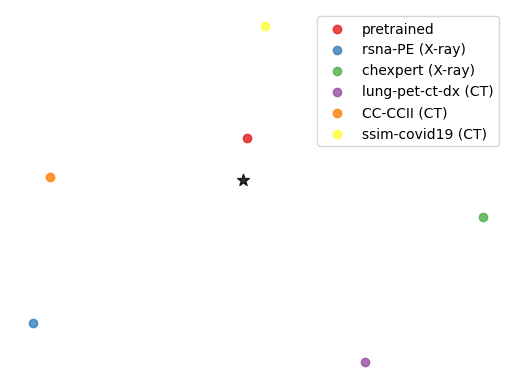

In [75]:
plt.figure()
plt.axis("off")

colors = list([plt.cm.Set1(i) for i in range(8)])

text_features_embedded = features_embedded[: len(texts)]
image_features_embedded = features_embedded[len(texts) :].reshape(len(subsets) + 1, 200, -1)

subsets_plot = ["pretrained"] + [
    "rsna-PE (X-ray)",
    "chexpert (X-ray)",
    "lung-pet-ct-dx (CT)",
    "CC-CCII (CT)",
    "ssim-covid19 (CT)",
]


for i in range(len(subsets) + 1):
    plt.scatter(
        image_features_embedded[i, 0, 0],
        image_features_embedded[i, 0, 1],
        c=colors[i],
        alpha=0.8,
        label=subsets_plot[i],
    )


plt.scatter(fused_image_features[0, 0], fused_image_features[0, 1], c="black", alpha=0.8, marker="*", s=80)

plt.legend()

text_features_embedded.shape

# plt.scatter(text_features_embedded[0, 0], text_features_embedded[0, 1], c="gray", marker="*", s=80)
# plt.scatter(text_features_embedded[1, 0], text_features_embedded[1, 1], c="black", marker="*", s=80)
# plt.scatter(text_features_embedded[2, 0], text_features_embedded[2, 1], c="black", marker="*", s=80)
# plt.scatter(text_features_embedded[3, 0], text_features_embedded[3, 1], c="black", marker="*", s=80)
# plt.scatter(text_features_embedded[4, 0], text_features_embedded[4, 1], c="black", marker="*", s=80)

# Evaluate results

In [168]:
texts = [
    "An image of diseased",
    "An image of no findings",
]

with torch.no_grad():
    text_embeddings = models[1].backbone.encode_text(texts).cpu()

In [169]:
text_embeddings.shape

torch.Size([2, 512])

In [170]:
test_set = MoEDataset(
    args=edict(input_size=224,
               data_root="/media/yesindeed/DATADRIVE1/mount/remote_cse/datasets/multitask-moe"),
    subsets="rsna-pulmonary-embolism",
    split="test",
)

datasamples = Subset(test_set, range(1000))

In [172]:
data_loader = DataLoader(datasamples, batch_size=1, shuffle=False)

image_features = []
labels = []

with torch.no_grad():
    features = []
    for batch in data_loader:
        image = batch["image"].cuda()

        feature = models[0].backbone.encode_image(image)
        features.append(F.normalize(feature, dim=-1))

        labels.append(batch["label"].squeeze()[0])

    features = torch.concat(features, dim=0).cpu().numpy()
    image_features.append(features)

    for model in tqdm(models):
        model.eval()

        features = []

        for batch in data_loader:
            image = batch["image"].cuda()

            feature = model.encode_image(image)

            features.append(feature)

        features = torch.concat(features, dim=0).cpu().numpy()
        image_features.append(features)

labels = torch.stack(labels).view(-1).cpu().numpy()

RuntimeError: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1

In [157]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [158]:
subsets_ = ["rsna-pulmonary-embolism", "chexpert", "lung-pet-ct-dx", "CC-CCII", "ssim-covid19"]

image_features_pretrained = torch.tensor(image_features[0])

image_features_adapted = image_features[1:]
image_features_adapted = torch.stack([torch.tensor(x) for x in image_features[1:]])

In [159]:
image_features_pretrained.shape

torch.Size([1000, 512])

In [160]:
image_features_adapted.shape

torch.Size([5, 1000, 512])

In [161]:
from sklearn.metrics import roc_auc_score

for i, subset in enumerate(subsets_):
    logits = models[0].backbone.logit_scale * \
        image_features_adapted[i] @ text_embeddings.t()

    logits = torch.softmax(logits, dim=-1)[:, -1].detach().cpu().numpy()

    auc = roc_auc_score(labels, logits)

    print(f"{subset}: {auc}")

rsna-pulmonary-embolism: 0.7061092268525175
chexpert: 0.682443690741007
lung-pet-ct-dx: 0.8930483544924767
CC-CCII: 0.6562280620141925
ssim-covid19: 0.703504157116154


In [162]:
models[0].backbone.logit_scale

85.2322769165039

In [163]:
logits = models[0].backbone.logit_scale * \
    image_features_pretrained @ text_embeddings.t()
logits = torch.softmax(logits, dim=-1)[:, -1].detach().cpu().numpy()

auc = roc_auc_score(labels, logits)
print(f"zero-shot: {auc}")

zero-shot: 0.7447369979108696


In [164]:
image_features_ood = torch.concat([image_features_adapted[0:1], image_features_adapted[2:]], dim=0)
image_features_ensembled = torch.mean(image_features_ood, dim=0)

logits = models[0].backbone.logit_scale * image_features_ensembled @ text_embeddings.t()
logits = torch.softmax(logits, dim=-1)[:, -1].detach().cpu().numpy()

auc = roc_auc_score(labels, logits)
print(f"ensemble-no-zs: {auc}")

ensemble-no-zs: 0.8477176036741632


In [165]:
image_features_ensembled = torch.mean(image_features_ood, dim=0) * 0.5 + image_features_pretrained * 0.5

logits = models[0].backbone.logit_scale * image_features_ensembled @ text_embeddings.t()
logits = torch.softmax(logits, dim=-1)[:, -1].detach().cpu().numpy()

auc = roc_auc_score(labels, logits)
print(f"ensemble: {auc}")

ensemble: 0.7847180519491503


## OOD: CXP

rsna-pulmonary-embolism: 0.4916133815216384

chexpert: 0.8632090528114993

lung-pet-ct-dx: 0.708120965001699

CC-CCII: 0.7538792615245214

ssim-covid19: 0.8346667490398378



zero-shot: 0.7366323788342137

ensemble-no-zs: 0.7897218875812149

ensemble: 0.7591254028562897

## OOD: lung pet ct dx

rsna-pulmonary-embolism: 0.7061092268525175

chexpert: 0.682443690741007

lung-pet-ct-dx: 0.8930483544924767

CC-CCII: 0.6562280620141925

ssim-covid19: 0.703504157116154

zero-shot: 0.7447369979108696

ensemble-no-zs: 0.8477176036741632

ensemble: 0.7847180519491503

In [ ]:
# ood: cxp
